## Node 기반 그래프 방식(수정)

In [22]:
import os
import json
from typing import TypedDict, List
from urllib.parse import urlparse, parse_qs
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, START, END


In [23]:
# 상태(state) 정의
class CommentState(TypedDict):
    url: str
    comments: List[str]
    summary: str
    error: str

In [24]:
# 환경 변수 로드 및 LLM 준비
load_dotenv()
llm = ChatOpenAI(model="gpt-4o", streaming=True)

In [25]:
# video_id 추출 함수 (내부용)
def extract_video_id(url: str) -> str:
    parsed_url = urlparse(url)
    if parsed_url.hostname and "youtube.com" in parsed_url.hostname:
        query_string = parse_qs(parsed_url.query)
        return query_string.get("v", [None])[0]
    elif parsed_url.hostname and "youtu.be" in parsed_url.hostname:
        return parsed_url.path[1:]
    return None

In [26]:
# 노드 1: video_id로 댓글 수집
def fetch_comments(state: CommentState) -> dict:
    import googleapiclient.discovery
    url = state.get("url", "")
    try:
        video_id = extract_video_id(url)
        if not video_id:
            raise ValueError("유효한 유튜브 URL에서 Video ID를 추출할 수 없습니다.")
        print(f"✅ 영상 ID 추출 성공: {video_id}")
        api_key = os.getenv("YOUTUBE_API_KEY")
        youtube = googleapiclient.discovery.build("youtube", "v3", developerKey=api_key)
        request = youtube.commentThreads().list(
            part="snippet", videoId=video_id, maxResults=100, order="relevance"
        )
        response = request.execute()
        comments = [
            item['snippet']['topLevelComment']['snippet']['textDisplay']
            for item in response['items']
        ]
        if not comments:
            raise ValueError("댓글이 없습니다.")
        print(f"✅ 1. 댓글 {len(comments)}개 수집 성공")
        return {"url": url, "comments": comments, "summary": "", "error": ""}
    except Exception as e:
        error_message = f"ERROR: 댓글 수집 중 오류 발생 - {e}"
        print(f"🚨 {error_message}")
        return {"url": url, "comments": [], "summary": "", "error": error_message}

In [27]:
# 노드 2: 댓글 요약 생성
def summarize_comments(state: CommentState) -> dict:
    comments = state.get("comments", [])
    url = state.get("url", "")
    video_id = extract_video_id(url)
    comments_str = "\n- ".join(comments)
    prompt = PromptTemplate.from_template(
        """당신은 주어진 유튜브 댓글들을 분석하여 요약내용을 JSON 형식으로 생성하는 AI 전문가입니다.
        댓글은 한국어와 영어가 섞여 있을 수 있습니다. 영어가 있다면 내용을 파악하여 자연스러운 한국어 기반으로 번역하고 요약에 포함시켜야 합니다.

        [분석할 댓글 내용]
        - {comments_str}

        [분석 대상 영상 ID]
        {video_id}

        ## 아래 JSON 형식을 준수하여 응답해주세요:
        - "description"은 2문장이 넘어가지 않도록 핵심만을 담아 **개조식**으로 작성, **댓글 내용이 긍정적인지, 부정적인지는 말하지 않아도 됨**
        - "positivie_percentage"는 긍정적인 키워드와 부정적인 키워드를 모두 분석해서 전체 키워드 중 긍정적인 키워드가 몇퍼센트인지 정확하게 분석해서 정수형으로 답변
        - "key_topics", "user_tips", "faq" 모두 핵심만을 담아 2개만 추출
        {{
          "overall_sentiment": {{"description": "📝 전반적인 댓글 내용을 요약 서술", "positive_percentage": "👍 긍정 반응의 비율(%)"}},
          "key_topics": ["🏷️ 주요 키워드 1", "🏷️ 주요 키워드 2"],
          "user_tips": ["💡 사용자 팁 요약 1", "💡 사용자 팁 요약 2"],
          "faq": ["❓ 자주 묻는 질문 요약 1", "❓ 자주 묻는 질문 요약 2"]
        }}"""
    )
    try:
        chain = prompt | llm | StrOutputParser()
        summary = chain.invoke({"comments_str": comments_str, "video_id": video_id})
        print(f"✅ 2. 요약 결과 생성 완료")
        return {"url": url, "comments": comments, "summary": summary, "error": ""}
    except Exception as e:
        error_message = f"ERROR: 요약 중 에러 발생 - {e}"
        print(f"🚨 {error_message}")
        return {"url": url, "comments": comments, "summary": "", "error": error_message}

In [28]:
# 에러 분기 함수
def route_after_fetch(state: CommentState) -> str:
    if state.get("error"):
        print("🚨 오류가 감지되어 프로세스를 종료합니다.")
        return END
    else:
        print("✅ 댓글 수집 성공. 요약 단계로 이동합니다.")
        return "summarize_comments"

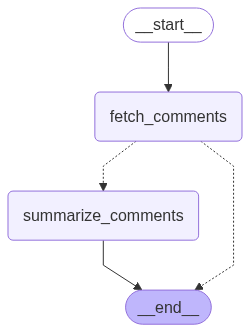

In [29]:
# 그래프(graph) 생성
builder = StateGraph(CommentState)
builder.add_node("fetch_comments", fetch_comments)
builder.add_node("summarize_comments", summarize_comments)

builder.add_edge(START, "fetch_comments")
builder.add_conditional_edges("fetch_comments", route_after_fetch, {
    "summarize_comments": "summarize_comments",
    END: END
})
builder.add_edge("summarize_comments", END)

graph = builder.compile()

graph

In [30]:
# 결과 출력 함수
def run_agent(url: str):
    """
    에이전트를 실행하고 최종 결과를 출력합니다.
    - 초기 입력을 'url' 필드에 담아 전달합니다.
    - 최종 결과는 'summary' 필드에서 가져옵니다.
    - 'error' 필드를 확인하여 오류를 처리합니다.
    """
    inputs = {"url": url}
    final_state = graph.invoke(inputs)

    if final_state.get("error"):
        print("\n" + "="*30)
        print("❌ 최종 실행 중 오류 발생:")
        print("="*30)
        print(final_state["error"])
        return

    content = final_state.get("summary", "")

    print("\n" + "="*30)
    print("✅ 최종 요약 (JSON 형식):")
    print("="*30)

    if not content or not content.strip():
        print("⚠️ 요약 결과가 비어 있습니다. content 값:", repr(content))
        return

    # LLM 응답에서 마크다운 코드 블록 제거
    if content.strip().startswith("```json"):
        start_index = content.find('{')
        end_index = content.rfind('}')
        if start_index != -1 and end_index != -1:
            content = content[start_index : end_index + 1]

    try:
        parsed_json = json.loads(content)
        print(json.dumps(parsed_json, indent=2, ensure_ascii=False))
    except json.JSONDecodeError:
        print("⚠️ JSON 파싱 실패. 원본 content 출력:")
        print(content)

In [31]:
# 테스트 실행 예시
if __name__ == "__main__":
    youtube_url = input("유튜브 영상 URL을 입력하세요: ")
    run_agent(youtube_url)

✅ 영상 ID 추출 성공: F0VqX7LzyvQ
✅ 1. 댓글 100개 수집 성공
✅ 댓글 수집 성공. 요약 단계로 이동합니다.
✅ 2. 요약 결과 생성 완료

✅ 최종 요약 (JSON 형식):
{
  "overall_sentiment": {
    "description": "📝 많은 사용자가 스트레칭 루틴의 효과를 높이 평가하며, 동작의 유연성과 개운함을 경험했음을 언급함. 특히 초보자도 쉽게 따라할 수 있는 점과 상세한 설명에 감사함을 나타냄.",
    "positive_percentage": 98
  },
  "key_topics": [
    "🏷️ 스트레칭 효과",
    "🏷️ 초보자 친화적"
  ],
  "user_tips": [
    "💡 꾸준히 따라하면 유연성과 개운함을 느낄 수 있음",
    "💡 영상의 상세한 설명을 활용하여 초보자도 쉽게 따라할 수 있음"
  ],
  "faq": [
    "❓ 스트레칭을 통해 유연성이 향상될 수 있나요?",
    "❓ 초보자도 쉽게 따라할 수 있는가요?"
  ]
}
